<a href="https://colab.research.google.com/github/muuki2/PracticalSessions2025/blob/main/reinforcement_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEML'25: **Reinforcement Learning** Tutorial
---
**Authors**:
* Miruna Pîslar (mirunapislar@google.com)
* Daniele Calandriello (dcalandriello@google.com)

Welcome! In this tutorial, we will guide you through the fundamentals of Reinforcement Learning (RL).

## Tutorial outline

*   **Setup & Installation**
    *   Note: Please run this section first to allow time for downloads to complete while you read the theory sections.
*   **Intro to Reinforcement Learning**: an overview of the main RL concepts.
*   **Practical 1**: build and train an agent from scratch using the **REINFORCE** algorithm.
*   **Practical 2 (Advanced)**: explore more powerful algorithms (A2C and PPO) by introducing concepts like value functions, advantage estimation, and entropy. This is an **optional** section for those who finish Practical 1 early or are already familiar with REINFORCE.
*   **Practical 3**: learn about **RL*F** (Reinforcement Learning from Feedback) and use it to fine-tune GPT-2 to generate more positive text.


## Setup and library installations
---

First, let's install the necessary libraries and import them. We will use [gymnasium](https://github.com/Farama-Foundation/Gymnasium) for our environment.

For the last part of the tutorial, we will make use of HuggingFace pre-trained models, through [trl](https://github.com/huggingface/trl) and [transformers](https://github.com/huggingface/transformers).

❗ Note: While a GPU is not mandatory for this tutorial, we recommend using it for Part 3 to speed up the training. You can do this by clicking `Runtime -> Change runtime type`, and set the hardware accelerator to GPU.

In [ ]:
#@title Downloads.
%%capture
!pip install trl==0.11.0 fsspec==2023.9.2 gymnasium


In [ ]:
#@title Imports & utils.
import glob
import io
import os
import base64
import time
from itertools import count

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
tqdm.pandas()

# Gymnasium environment and Torch.
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# For HuggingFace pre-trained models.
from datasets import load_dataset
from transformers import AutoTokenizer, pipeline, GenerationConfig, AutoModelForSequenceClassification
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model

# For visualization
import io
import glob
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay


# A reusable visualization function.
def visualise_policy(
    policy: nn.Module,
    env_id: str = "CliffWalking-v1",
    max_episode_steps: int = 200,
    folder: str = "./videos",
):
    """
    Renders a video of a policy acting in an environment.

    Args:
        env_id (str): The ID of the gymnasium environment.
        policy (nn.Module): The policy to be visualized.
        max_episode_steps (int): The maximum number of steps per episode.
        folder (str): The directory to save the video in.
    """
    # Create a new environment for recording.
    video_env = gym.make(env_id, render_mode="rgb_array")
    recorder_env = RecordVideo(video_env, folder, name_prefix=f"vis-{env_id}")

    state, _ = recorder_env.reset()
    policy.eval() # Set the policy to evaluation mode.

    for _ in range(max_episode_steps):
        with torch.no_grad(): # No need to track gradients for visualization.
            # Handle different state types (int for discrete, numpy for continuous).
            if isinstance(state, np.ndarray):
                state_tensor = torch.tensor(state, dtype=torch.float32)
            else: # Assumes int for discrete environments like CliffWalking.
                state_tensor = torch.tensor(state)

            # Get action probabilities from the policy.
            action_logits = policy(state_tensor)
            if isinstance(action_logits, tuple):
              action_logits, _ = policy(state_tensor)

            action_probs = F.softmax(action_logits, dim=-1)
            action = Categorical(action_probs).sample().item()

        state, _, terminated, truncated, _ = recorder_env.step(action)
        done = terminated or truncated
        if done:
            break

    recorder_env.close()

    # Display the video.
    mp4list = glob.glob(f'{folder}/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=os.path.getmtime)[-1]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data=f'''<video alt="test" autoplay
                    loop controls style="height: 200px;">
                    <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4" />
                </video>'''))
    else:
        print(f"Could not find video in folder: {folder}")


# Utils for reward shaping.
def get_shaped_reward(
    env: gym.Env,
    original_reward: float,
    state: int,
    next_state: int,
    gamma: float = 0.99,
    still_penalty: float = -2.0,
    potential_multiplier: float = 5.0,
) -> float:
    """
    Calculates a shaped reward to better guide the agent.

    Args:
        env: Environment instance.
        original_reward: Reward received from env.step().
        state: Current state (before the action).
        next_state: Next state (after the action).
        gamma: Discount factor.
        still_penalty: Penalty for not changing the state (i.e., inactivity).
        potential_multiplier: Factor to amplify the potential-based pull.

    Returns:
        The newly calculated shaped reward.
    """
    shaped_reward = original_reward
    if state == next_state:  # penalty for staying in place.
        shaped_reward += still_penalty

    unwrapped_env = env.unwrapped
    goal_state = unwrapped_env.observation_space.n - 1
    goal_pos = np.unravel_index(goal_state, unwrapped_env.shape)

    current_pos = np.unravel_index(state, unwrapped_env.shape)
    next_pos = np.unravel_index(next_state, unwrapped_env.shape)

    dist_to_goal_current = np.linalg.norm(np.array(current_pos) - np.array(goal_pos))
    dist_to_goal_next = np.linalg.norm(np.array(next_pos) - np.array(goal_pos))

    potential_current = -potential_multiplier * dist_to_goal_current
    potential_next = -potential_multiplier * dist_to_goal_next

    shaped_reward += (gamma * potential_next - potential_current)

    return shaped_reward

## Intro to Reinforcement Learning
---

Reinforcement Learning (RL) is about learning to make good decisions through trial and error. An **agent** (our learner) interacts with an **environment** (the world or game it's in) by taking **actions**. After each action, the environment provides a **reward** (a score) and a new **state** (the new observation of the world).

This interaction follows a basic loop:

1. The agent observes the current **state** $s_t$.
2. It selects an **action** $a_t$ using its **policy** $\pi$.
3. The environment transitions to a **new state** $s_{t+1}$ and provides a **reward** $r_t$.
4. The cycle repeats.


<img src="https://wizzdev.com/wp-content/uploads/2024/07/2_ML_concept.png" alt="agent-environment" width="500"/>


### 🔁 Key Concepts

* **Timestep** $t$: A single step in the environment, where the agent receives state $s_t$, takes action $a_t$, and gets reward $r_t$ and the next state $s_{t+1}$.

* **Episode**: A full run from a starting state to a terminal state. For example, a full game from start to crash. This is also called a **trial** or a **trajectory**:

  $$
  \tau = (s_0, a_0, r_0, s_1, a_1, r_1, \dots, s_T)
  $$

### The environment we'll work with
---

[Gymnasium](https://gymnasium.farama.org/index.html) is a standard suite for loading reinforcement learning environments.

For this tutorial, we will use the [CliffWalking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) environment. This is a `4x12` grid world environment. The agent starts at the bottom-left corner (at location $[3,0]$) and must reach the goal at the bottom-right (location $[3,11]$). The agent should follow the "safe path" (grass) and avoid the cliff area (in brown), which results in a large penalty if stepped on.

![CliffWalking environment](https://gymnasium.farama.org/_images/cliff_walking.gif)

In [ ]:
#@title Load the "CliffWalking" environment.

env = gym.make("CliffWalking-v1")
num_states = env.observation_space.n
num_actions = env.action_space.n

print(f"Observation space (4x12): {env.observation_space}")
print(f"Action space (up, right, down, left): {env.action_space}")

Observation space (4x12): Discrete(48)
Action space (up, right, down, left): Discrete(4)



The agent's **goal** is to learn the shortest path from the starting position 🪑 to the cookie 🍪.

The agent's **state** is an integer representing the player’s current position, calculated as `current_row * 12 + current_col`. For example, the starting position can be calculated as follows: 3 * 12 + 0 = 36.

The agent's **actions** are simply 4 basic moves, which are represented by 4 integers: UP (coded by 0), RIGHT (1), DOWN (2), and LEFT (3).

The **reward** given by the environment after each step is:

  * `-1` for every step on the safe path (grass).
  * `-100` for falling off the cliff, which also ends the episode.
  * Reaching the goal gives no additional reward, and ends the episode.

**Question:** What is the **maximum** total reward the agent can receive if it achieves its goal?

### 🎯 Goal: maximize expected reward
---

In reinforcement learning, the agent’s goal is to collect as much reward as possible over time. We define this using the **return**, denoted $G_t$, which is the **discounted sum of future rewards starting at time step $t$**:

$$
G_t = \sum_{k=0}^{∞} \gamma^{k} r_{t+k+1}
$$

where $r_{t+k+1}$ is the reward received $k+1$ steps into the future.

Here, $\gamma \in [0,1]$ is the **discount factor**. It determines how much the agent prioritizes long-term rewards over short-term ones. A discount factor close to 1 (e.g., 0.99) means the agent considers future rewards nearly as important as immediate rewards, whereas a value closer to 0 makes it focus more heavily on short-term outcomes.

> 💡 Although often treated as a hyperparameter, $\gamma$ is better viewed as part of the **problem definition**, not just something to tune for performance (like the learning rate).


#### ✏️ **Exercise: Calculate the discounted returns $G_t$**

Let's calculate the **discounted return** $G_t$ for every step $t$ in an episode. This value represents the total future reward from that step onwards.

For an episode that ends at a final timestep $T$ (e.g., reaching the goal or falling off the cliff), the discounted return is the finite sum:

$$
G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^{T-t} r_{T} = \sum_{k=0}^{T-t-1} \gamma^k r_{t+k+1}
$$

Now, let's implement this logic in code.

> Hint: Can you define this recursively?

<details>
<summary>💡 Hints</summary>

* Use the recursive form: $G_t = r_t + \gamma G_{t+1}$.

*   The easiest way is to work backward from the last reward to the first.

*   Keep a running total for the return, starting at 0.

*   In each backward step, update the total using the formula: `return = reward + gamma * return`.

*   Add each new return you calculate to the front of your results list.

*   Python's `reversed()` function is perfect for looping backward
</details>

In [ ]:
# Implement discount return for each step t \in [0,T].

def get_returns(gamma: float, rewards: list[float], standardize: bool = True) -> torch.Tensor:
    """
    Calculates the discounted returns for the entire rewards history.
    """
    returns = []
    discounted_return = 0

    ################################################################
    # Compute the returns for each step.

    for r in reversed(rewards):
      discounted_return = r + gamma * discounted_return
      returns.insert(0, discounted_return)

    ################################################################

    # Cast to float.
    returns = torch.tensor(returns, dtype=torch.float32)

    # Standardize returns for stability (optional, but good practice).
    if standardize:
      eps = 1e-9  # Small constant for numerical stability.
      returns = (returns - returns.mean()) / (returns.std() + eps)

    return returns

In [ ]:
#@title Test your implementation!

def test_get_returns():
    rewards = [1, 1, 1]  # Simple reward sequence.
    gamma = 0.9

    # Expected discounted returns (no standardization):
    # G_0 = 1 + 0.9*1 + 0.9^2*1 = 1 + 0.9 + 0.81 = 2.71
    # G_1 = 1 + 0.9*1 = 1 + 0.9 = 1.9
    # G_2 = 1
    expected_returns = torch.tensor([2.71, 1.9, 1.0], dtype=torch.float32)

    returns_unstandardized = get_returns(gamma, rewards, standardize=False)

    assert torch.allclose(returns_unstandardized, expected_returns, atol=1e-2), \
        f"Expected {expected_returns}, but got {returns_unstandardized}"

    print("✅ Test passed: discounted returns are correct!")

test_get_returns()

✅ Test passed: discounted returns are correct!


### Agent Policy
---

The agent's "brain" is its **Policy ($\pi$)**, which is a function that decides which action to take in a given state.

Formally, a policy is a mapping from states to a probability distribution over actions.

$$
\pi(a | s) = \text{probability of taking action } a \text{ in state } s
$$

This means that in a state $s$, the policy doesn't just output a single best action. Instead, it gives a probability for *every* possible action. This allows the agent to explore by sometimes trying actions that don't have the highest probability, which is crucial for discovering new, better strategies.

### From Policy Output to Action

So, how do we get from a state to a concrete action? It's a simple three-step process:

1.  **Get Action Scores (Logits)**: The policy takes the current state and outputs a raw score for each possible action; these scores are called **logits**.

2.  **Convert to Probabilities (Softmax)**: Logits are just numbers; they can be positive or negative and don't sum to 1. To turn them into a valid probability distribution, we use the **softmax function**.

    `Logits [2.0, 1.0, 0.1]  →  Softmax  →  Probabilities [0.66, 0.24, 0.09]`

3.  **Sample an Action**: The agent then samples an action from this probability distribution. This means an action with a higher probability is more likely to be chosen, but it's not guaranteed.

This entire process ensures that the agent's actions are guided by its learned preferences (the logits) while still allowing for **exploration**.

### Implementing a Policy

We can implement a policy in different ways. The two we will cover are:

*   **Tabular Policy**: A simple lookup table. For each state, we store a list of action logits. This works perfectly for small environments like CliffWalking where we can list every possible state.
*   **Neural Network Policy**: A more powerful function approximator that can handle environments with big or continuous state spaces (e.g., controlling a robot from camera images).

We will start with a tabular policy, as it's the easiest to understand and implement.

#### ✏️ **Exercise: Implement a tabular policy**

Let's build a tabular policy called `GridPolicy`. The `forward` method has already been completed: it takes an observation (the agent's current location) and returns action logits.

Your task is to instantiate the policy: create a learnable table of size `[number of states, number of actions]`. This table will hold the policy's logits.

<details>
<summary>💡 Hints</summary>

*   First, create a tensor of random values using `torch.randn()`.

* Think about the shape of this tabular policy: what is the shape of the table? Does it depend on the environment?

*   To make this tensor a learnable parameter of the module, wrap the tensor you created inside `nn.Parameter()`.

</details>

In [ ]:
class GridPolicy(nn.Module):
    """
    A policy for environments with a discrete state space (like a grid).
    It's a simple table mapping each state to action logits.
    """
    def __init__(self, num_states: int, num_actions: int):
        super().__init__()
        ################################################################
        # Create a learnable parameter of size [num_states, num_actions].
        # Your solution:
        # self.policy = ...
        ################################################################
        self.policy = nn.Parameter(torch.randn(num_states, num_actions))
    def forward(self, obs: int) -> torch.Tensor:
        """
        Given an observation (state), return action logits.
        """
        action_logits = self.policy[obs]
        return action_logits

In [ ]:
# Let's instantiate the Grid policy and print the action logits for a custom state.

untrained_policy = GridPolicy(num_states=num_states, num_actions=num_actions)
test_obs = 20  #@param
logits = untrained_policy(test_obs)
print(f"Action logits for state {test_obs}: {logits.detach().numpy()}")

# We can also use PyTorch's Categorical distribution to see the probabilities
# and sample an action.
action_distribution = Categorical(logits=logits)
probabilities = action_distribution.probs
sampled_action = action_distribution.sample()

print(f"Probabilities: {probabilities.detach().numpy()}")
print(f"Sampled Action: {sampled_action.item()}")

Action logits for state 20: [-1.6563737  -0.36755514 -1.8195271  -0.40065485]
Probabilities: [0.11125552 0.4036903  0.09450719 0.390547  ]
Sampled Action: 3


In [ ]:
#@title Watch your untrained GridPolicy *random* agent!

print("Visualizing an untrained GridPolicy with random weights...")
visualise_policy(
    policy=untrained_policy,
    max_episode_steps=50,
)

Visualizing an untrained GridPolicy with random weights...


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


# 🛠️ Practical 1: REINFORCE

### The REINFORCE algorithm
---

We have a policy, but how does it actually learn which actions to take?

We'll use a famous policy gradient algorithm called **REINFORCE**. The core idea is intuitive:

> If a trajectory had a high return, increase the probability of the actions taken in that trajectory. If it had a low return, decrease their probability.

This is a form of trial-and-error learning. We're "reinforcing" good behaviors.

### Agent's goal: maximizing expected return
---

Mathematically, our goal is to find the policy parameters, $\theta$, that maximize the expected total discounted return, which is our objective function $J(\theta)$.

$$
\max_{\theta} J(\theta) \quad \text{where} \quad J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}[G(\tau)]
$$

This means we want to find the parameters $\theta$ that, on average, produce trajectories ($\tau$) with the highest possible total return $G(\tau)$. The standard way to maximize a function is **gradient ascent**: we calculate the gradient of the objective with respect to the parameters, $\nabla_\theta J(\theta)$, and take a small step in that direction.

$$
\theta \leftarrow \theta + \eta \nabla_\theta J(\theta)
$$

where $\eta$ is the learning rate.


<details>

<summary> Challenge: finding the Policy Gradient</summary>

The tricky part is calculating the gradient $\nabla_\theta J(\theta)$. Let's write out the expectation to see why:

$$
\nabla_\theta J(\theta) = \nabla_\theta \mathbb{E}_{\tau \sim \pi_\theta}[G(\tau)] = \nabla_\theta \sum_{\tau} P(\tau|\theta) G(\tau)
$$

Here, $P(\tau|\theta)$ is the probability of a specific trajectory $\tau$ occurring under our policy $\pi_\theta$. We run into two major problems:

1.  **The gradient is outside an expectation that depends on $\theta$**. The distribution of trajectories we sample from, $P(\tau|\theta)$, changes as we change our policy parameters $\theta$. We can't just move the gradient inside the expectation, because the thing we are averaging over depends on the variable we're differentiating with respect to.

2.  **The trajectory probability depends on the unknown environment dynamics**. The probability of a trajectory is a product of the policy's action probabilities and the environment's transition probabilities:

$$
P(\tau|\theta) = p(s_0) \prod_{t=0}^{T-1} \underbrace{\pi_\theta(a_t|s_t)}_{\text{Our policy}} \cdot \underbrace{p(s_{t+1}|s_t, a_t)}_{\text{Environment}}
$$

To compute the gradient $\nabla_\theta P(\tau|\theta)$, we would need to know the environment dynamics, $p(s_{t+1}|s_t, a_t)$, which in most interesting problems is unknown and complex. We can't differentiate a function we don't know!

We seem to be stuck. How can we get a gradient that depends only on our policy and is easy to estimate from experience? This is where the **Policy Gradient Theorem** comes to the rescue.

The theorem provides a clever way to rewrite the gradient, turning an intractable problem into a solvable one. It accomplishes two things: it moves the gradient operator *inside* the expectation, and it eliminates the need for the environment model.

</details>

<details>
<summary> The Log Trick </summary>

The key mathematical insight is a simple identity from calculus called the "log-derivative trick" or "log-prob trick": for any positive, differentiable function $f(x)$, its derivative can be written as:

$$
\nabla f(x) = f(x) \frac{\nabla f(x)}{f(x)} = f(x) \nabla \log f(x)
$$

We can apply this to our trajectory probability, $P(\tau|\theta)$:

$$
\nabla_\theta P(\tau|\theta) = P(\tau|\theta) \nabla_\theta \log P(\tau|\theta)
$$

Now we can substitute this back into our gradient calculation:

$$
\begin{aligned}
\nabla_\theta J(\theta) &= \nabla_\theta \sum_{\tau} P(\tau|\theta) G(\tau) \\
&= \sum_{\tau} \nabla_\theta P(\tau|\theta) G(\tau) \\
&= \sum_{\tau} P(\tau|\theta) \nabla_\theta \log P(\tau|\theta) G(\tau) \\
&= \mathbb{E}_{\tau \sim \pi_\theta} \left[ G(\tau) \cdot \nabla_\theta \log P(\tau|\theta) \right]
\end{aligned}
$$

This is a beautiful result! We've successfully moved the gradient operator inside the expectation. Now, we can estimate this gradient by simply running our policy and averaging the results—a **Monte Carlo** approach.

</details>


<details>
<summary> Getting rid of the environment model </summary>

But what about the second problem? Doesn't $\nabla_\theta \log P(\tau|\theta)$ still depend on the environment dynamics? Let's expand it.

Remember, the log of a product is the sum of logs:

$$
\log P(\tau|\theta) = \log p(s_0) + \sum_{t=0}^{T-1} \left( \log \pi_\theta(a_t|s_t) + \log p(s_{t+1}|s_t, a_t) \right)
$$

Now, let's take the gradient with respect to our policy parameters, $\theta$:

$$
\nabla_\theta \log P(\tau|\theta) = \nabla_\theta \left[ \log p(s_0) + \sum_{t=0}^{T-1} \log \pi_\theta(a_t|s_t) + \sum_{t=0}^{T-1} \log p(s_{t+1}|s_t, a_t) \right]
$$

The parameters $\theta$ are only in our policy, $\pi_\theta$. The environment dynamics $p(s_{t+1}|s_t, a_t)$ and the initial state distribution $p(s_0)$ **do not depend on $\theta$**. Therefore, their gradients are zero!

$$
\nabla_\theta \log P(\tau|\theta) = \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t)
$$

This is the final piece of the puzzle. The gradient of the log-probability of a trajectory is just the sum of the gradients of the log-probabilities of the actions taken.

</details>

<details>
<summary>Further reading</summary>

Check out [Lil'Log blogpost](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/) about policy gradient algorithms.

</details>

### From theory to practice: the REINFORCE update rule
---

Combining our results, we get the final expression for the policy gradient:

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ G(\tau) \sum_{t=0}^{T-1} \nabla_\theta \log \pi_\theta(a_t|s_t) \right]
$$

This is an expectation, which we can approximate by running our policy to collect a batch of $N$ episodes (trajectories) and then averaging the results.

One final, crucial optimization is based on **causality**. The action taken at timestep $t$ can only affect rewards from timestep $t$ onwards. It cannot affect past rewards. Therefore, to credit an action $a_t$, we should only use the return starting from that step, $G_t$.

Replacing the full trajectory return $G(\tau)$ with $G_t$ for each action's gradient term reduces variance and leads to more stable and faster learning.

This gives us our final, practical formula for the gradient, which is the core of the **REINFORCE** algorithm. We estimate it by averaging over all the steps in our batch of episodes:

$$
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=0}^{T_i-1} G_{i,t} \cdot \nabla_\theta \log \pi_\theta(a_{i,t} | s_{i,t})
$$

👨‍💻 Let's break this down one last time:
*   We collect a batch of $N$ trajectories using our current policy $\pi_\theta$.
*   For each step $t$ in each trajectory $i$:
    *   We calculate the return, $G_{i,t}$.
    *   We calculate the gradient of the log-probability of the action we took, $\nabla_\theta \log \pi_\theta(a_{i,t} | s_{i,t})$. This term tells us which direction in parameter space would make that action more likely.
    *   We scale this direction vector by the return $G_{i,t}$. If the future return was high, we push the parameters in that direction. If it was low (or negative), we push them in the opposite direction.
*   We average all these scaled vectors together to get our final estimate of the policy gradient, and then update our parameters $\theta$.

✨ In the next exercise, you will implement the REINFORCE loss function.

### Building a learning agent: implementation considerations
---

To keep our code clean and easy to understand, we'll separate our learning system into 3 components: the **Policy**, the **Agent**, and the **Algorithm**.

1.  **Policy**: the "brain" of our operation.
    *   **Role**: To decide which action to take in a given state. It maps a state to action logits. It contains the learnable parameters (the weights).
    *   **Implementation**: The `GridPolicy` class. Later we'll implement  it as a neural network (`NNPolicy`).

2.  **Agent**: the "body" or the complete entity that interacts with the world.
    *   **Role**: It holds a policy and uses it to act in the environment. It's also responsible for collecting experience (the sequences of states, actions, and rewards). Crucially, it orchestrates the entire learning process.
    *   **Implementation**: We will soon create a class called `ReinforceAgent`.

3.  **Learning Algorithm**: the "training rule" that enables learning.
    *   **Role**: It takes the experience collected by the Agent and uses it to update the Policy's parameters, making the policy better over time.
    *   **Implementation**: The algorithm is the logic *inside* our Agent's `.update()` method. In this tutorial, the algorithm we will implement is called **REINFORCE**.

This modular design is very convenient. Our `ReinforceAgent` will be able to train *any* kind of policy (`Grid_Policy`, `NN_Policy`, etc.) because the learning algorithm is separate from the policy's internal structure.

```
┌────────────────────────────────┐
│   ReinforceAgent               │
│  (The complete learner)        │
│                                │
│   ┌────────────────────────┐   │  <── The Agent HOLDS a Policy
│   │         Policy         │   │
│   │ (e.g., Grid_Policy or  │   │
│   │      NN_Policy)        │   │
│   └────────────────────────┘   │
│                                │
│   → select_action() uses Policy│  <── The Agent USES the Policy to act
│   → update() implements        │  <── The Agent USES the Algorithm to learn
│     REINFORCE Algorithm        │
└────────────────────────────────┘
```

#### ✏️ **Exercise: Implement the REINFORCE Loss**

Now we'll create the `ReinforceAgent`. The Agent takes as input a policy to choose actions (we will re-use the `GridPolicy` you implemented above) and implements the logic for updating the policy's parameters using the REINFORCE algorithm.

Your task is to implement the REINFORCE loss using the `get_returns` function you already implemented above.

> Note: Optimizers in PyTorch perform gradient *descent* (minimization). As we saw, the objective is to *maximize* $\log \pi_\theta(a_t|s_t) * G_t$, so we'll implement our loss as the *negative* of this objective:

$$ \text{REINFORCE loss} = - \sum_{t=0}^{T} \log \pi_\theta(a_t | s_t) \cdot G_t $$

<details>
<summary>💡 Hints</summary>

*   Your goal is to translate the REINFORCE loss formula into code.

*   Start by multiplying the `log_probs` tensor with the `returns` tensor. This operation is element-wise.

*   Sum up all the elements of the resulting tensor to get a single scalar value. The `torch.sum()` function is what you need.

*   Remember to put a negative sign in front of the final sum. This is because optimizers minimize a loss, but we want to maximize our objective.

</details>

In [ ]:
class ReinforceAgent(nn.Module):
    """Implements the REINFORCE algorithm."""

    def __init__(self, policy: nn.Module, gamma: float = 0.99):
        super().__init__()
        self.policy = policy
        self.gamma = gamma

    def forward(self, obs: int) -> tuple[int, torch.Tensor]:
        """
        Selects an action and returns it along with its log-probability.

        Args:
            obs: The current observation (state) from the environment.

        Returns:
            A tuple containing:
            - int: The action selected by the policy.
            - torch.Tensor: The log-probability of the selected action.
        """
        # Get action logits from the policy network.
        logits = self.policy(obs)

        # Create a probability distribution directly from logits.
        distribution = Categorical(logits=logits)

        # Sample an action from the distribution and get log-prob.
        action = distribution.sample()
        log_prob_action = distribution.log_prob(action)

        return action.item(), log_prob_action

    def calculate_reinforce_loss(
        self, returns: torch.Tensor, log_probs: torch.Tensor
    ) -> torch.Tensor:
        """
        Calculates the REINFORCE loss for a single episode.

        Args:
            returns: A tensor of discounted returns for one episode.
            log_probs: A tensor of the log_probs for the actions in that episode.

        Returns:
            A tensor representing the calculated loss for the episode.
        """
        ################################################################
        # Calculate the REINFORCE loss.
        # Your solution:
        loss = -torch.dot(returns, log_probs)
        ################################################################
        return loss

    def update(
        self,
        batch_log_probs: list[list[torch.Tensor]],
        batch_rewards: list[list[float]],
        optimizer: optim.Optimizer,
    ):
        """
        Performs the learning step for a batch of episodes.

        For each episode in the batch:
            * Calculates discounted returns from the stored rewards.
            * Stacks the log_probs into a tensor.
            * Computes the REINFORCE loss for the episode.
            * Appends the episode loss to the list of losses.
        Then, it averages the losses across the batch and performs a gradient
        ascent step to update the policy.
        """
        batch_loss = []
        # Iterate over each episode in the batch.
        for episode_rewards, episode_log_probs in zip(batch_rewards, batch_log_probs):
            returns = get_returns(gamma=self.gamma, rewards=episode_rewards)
            log_probs = torch.stack(episode_log_probs)
            episode_loss = self.calculate_reinforce_loss(returns, log_probs)
            batch_loss.append(episode_loss)
        average_batch_loss = torch.stack(batch_loss).mean()

        # Perform the gradient ascent step
        optimizer.zero_grad()
        average_batch_loss.backward()
        optimizer.step()

In [ ]:
#@title Test your implementation of the `calculate_reinforce_loss` method.

def test_agent_loss_method():
    agent = ReinforceAgent(policy=untrained_policy)
    returns = torch.tensor([2.0, -0.5, -1.0])
    log_probs = torch.tensor([-0.5, -1.0, -0.2])
    calculated_loss = agent.calculate_reinforce_loss(returns, log_probs)

    # Expected: -sum([-0.5*2.0, -1.0*-0.5, -0.2*-1.0]) = -sum([-1.0, 0.5, 0.2]).
    expected_loss = torch.tensor(0.3)

    if torch.isclose(calculated_loss, expected_loss):
        print("✅ TEST PASSED!")
        print(f"Your loss: {calculated_loss.item():.1f}, "
              f"Expected loss: {expected_loss.item():.1f}")
    else:
        print("❌ TEST FAILED!")
        print(f"Your loss: {calculated_loss.item():.1f}, "
              f"Expected loss: {expected_loss.item():.1f}")

# Run the test
test_agent_loss_method()

✅ TEST PASSED!
Your loss: 0.3, Expected loss: 0.3


### Training loop for the REINFORCE Agent

We now have all the components. The final step is to orchestrate the agent-environment interaction. The loop will look like this:

1.  Play a number of episodes (`episodes_per_batch`).
2.  In each episode:
    -   Reset the environment.
    -   Loop until the episode is `done` (terminated or truncated):
        -   The agent chooses an action.
        -   The environment gives a new state and reward.
        -   Store the reward in the agent's history.
3.  After collecting data from the batch, call `agent.update()` to learn.
4.  Repeat for a number of updates.

Read through the training loop implementation below.

In [ ]:
def train_agent(
    env: gym.Env,
    agent: ReinforceAgent,
    optimizer: optim.Optimizer,
    num_updates: int,
    episodes_per_batch: int,
    max_episode_steps: int,
    convergence_threshold: float,
    log_frequency: int,
):
    """
    A generic function to train a REINFORCE agent.

    Args:
        env: The gymnasium environment to train in.
        agent: The ReinforceAgent to train.
        optimizer: The optimizer for the agent's policy.
        num_updates: The total number of policy updates to perform.
        episodes_per_batch: The number of episodes to run per policy update.
        max_episode_steps: The maximum steps allowed per episode.
        convergence_threshold: The average reward to aim for to "solve" the env.
        log_frequency: How often (in updates) to print progress.

    Returns:
        A tuple of avg_rewards for plotting.
    """
    avg_rewards = []

    print(f"Starting training for {agent.policy.__class__.__name__}...")
    pbar = tqdm(range(num_updates), mininterval=2)
    for i in pbar:
        # These lists will store the experience for the entire batch.
        batch_rewards = []
        batch_log_probs = []
        batch_episode_rewards = []

        for _ in range(episodes_per_batch+1):
            episode_rewards = []
            episode_log_probs = []
            total_episode_reward = 0
            state, _ = env.reset()

            for step in range(max_episode_steps):
                # This is to handle state differences between environments:
                # e.g., int for CliffWalking, numpy array for CartPole.
                if isinstance(state, np.ndarray):
                    state_tensor = torch.tensor(state, dtype=torch.float32)
                else:
                    state_tensor = state

                # Get action & log_prob from the agent.
                action, log_prob = agent(state_tensor)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                # *** Apply reward shaping for faster convergence ***
                shaped_reward = get_shaped_reward(env, reward, state, next_state)

                # Store experience for the current episode.
                episode_rewards.append(shaped_reward)
                episode_log_probs.append(log_prob)
                total_episode_reward += reward
                state = next_state

                if done:
                    break

            # After the episode is done, add its history to the batch history.
            batch_rewards.append(episode_rewards)
            batch_log_probs.append(episode_log_probs)
            batch_episode_rewards.append(total_episode_reward)

        # 2. Update the agent's policy using the collected batch of experience.
        agent.update(batch_log_probs, batch_rewards, optimizer)

        # 3. Logging.
        avg_reward_for_batch = np.mean(batch_episode_rewards)
        avg_rewards.append(avg_reward_for_batch)

        if i % log_frequency == 0:
            print()
        pbar.set_postfix(avg_reward=f"{avg_reward_for_batch:.2f}")

        # 4. Check for convergence.
        if avg_reward_for_batch > convergence_threshold:
            print(f"\nSolved at update {i}!")
            break

    return avg_rewards

Let's run the training loop for the ReinforceAgent training a GridPolicy.

There's nothing for you to code, but feel free to experiment with the hyperparameters! 🚀

In [ ]:
# --- Hyperparameters ---
TABULAR_LEARNING_RATE = 0.1  # @param
TABULAR_GAMMA = 0.95  # @param
TABULAR_NUM_UPDATES = 700  # @param
TABULAR_EPISODES_PER_BATCH = 10  # @param
TABULAR_MAX_EPISODE_STEPS = 100  # @param


# --- Initialization ---
grid_policy = GridPolicy(num_states, num_actions)
grid_agent = ReinforceAgent(grid_policy, gamma=TABULAR_GAMMA)
grid_optimizer = optim.Adam(grid_policy.parameters(), lr=TABULAR_LEARNING_RATE)


# --- Run Training ---
grid_avg_rewards = train_agent(
    env=env,
    agent=grid_agent,
    optimizer=grid_optimizer,
    num_updates=TABULAR_NUM_UPDATES,
    episodes_per_batch=TABULAR_EPISODES_PER_BATCH,
    max_episode_steps=TABULAR_MAX_EPISODE_STEPS,
    convergence_threshold=-15,
    log_frequency=50,
)

Starting training for GridPolicy...


  0%|          | 0/700 [00:00<?, ?it/s]

Let's plot the learning progress. You should see the average reward increase 📈.

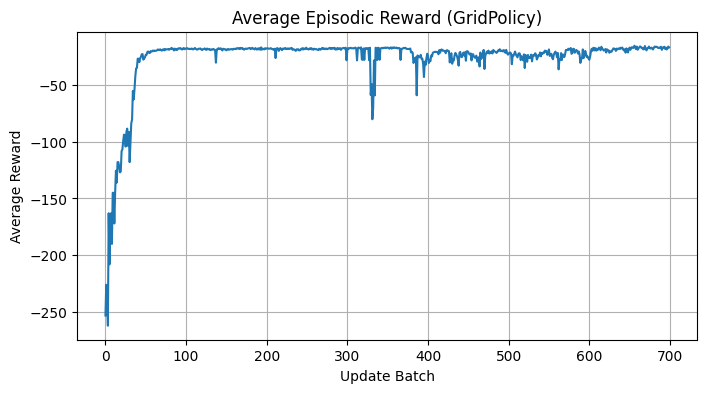

In [ ]:
#@title Plotting learning progress for the Reinforce Agent with GridPolicy.
plt.figure(figsize=(8, 4))
plt.plot(grid_avg_rewards)
plt.title("Average Episodic Reward (GridPolicy)")
plt.xlabel("Update Batch")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

In [ ]:
#@title Watch your trained GridPolicy REINFORCE agent!

visualise_policy(
    policy=grid_agent.policy,
    max_episode_steps=TABULAR_MAX_EPISODE_STEPS
)

### A More General Approach: The Neural Network Policy

Our `Grid_Policy` (a lookup table) worked, but for larger or continuous state spaces, tables quickly become impractical.

We can replace our specialized table with a general-purpose **function approximator**: a neural network (NN) 🕸️. While it may seem like overkill here, it's a good exercise to show how we can apply these more powerful models.

Neural networks require inputs to be vectors, not single integers. So we need to convert a state like `27` into a vector format.

The standard method is **one-hot encoding**: we create a vector with one entry for each possible state (e.g., 48 total), all set to `0`, and set the element at index `27` to `1`.

For example:

```
state = 27  
=>  
one_hot_vector = [0, 0, ..., 1, 0, ...]  # 1 at index 27
```

Now, let’s build a policy that performs this encoding and feeds the result into a simple MLP.

#### ✏️ **Exercise: Define the NN Architecture**

First, complete the `__init__` method by defining a simple 2-3 layer MLP using `nn.Sequential`. Make sure that your input dimension will be the total number of states. Then, complete the `forward` method. This is where you'll convert the integer observation into a one-hot vector before passing it to your network.

<details>
<summary>💡 Hints</summary>

For the `__init__` method:

*   Use `nn.Sequential` to define the network architecture.
*   Your **first** layer should be an `nn.Linear` that maps `num_states` to a hidden size (e.g., 32).
*   Follow this with an `nn.ReLU()` activation function.
*   Your **last** layer should be an `nn.Linear` that maps the hidden size to `num_actions`.
*   Feel free to add extra layers and play with the number of hidden sizes.

For the `forward` method:

*   Use the `F.one_hot()` function to convert the integer observation into a one-hot vector.
*   Make sure to set the `num_classes` argument in `F.one_hot()` to `self.num_states`.

</details>

In [ ]:
class NNPolicy(nn.Module):
    """
    A policy parameterized by a neural network. It uses one-hot encoding
    to handle discrete state spaces.
    """
    def __init__(self, num_states: int, num_actions: int):
        super().__init__()
        self.num_states = num_states

        ################################################################
        # Build a simple 2-3 layer MLP for the policy.
        # Your solution:
        hidden_dim1 = 128
        hidden_dim2 = 64
        self.policy_net = nn.Sequential(
            nn.Linear(num_states, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, num_actions)
        )
        ################################################################

    def forward(self, obs: int) -> torch.Tensor:
        """
        Performs a forward pass. It takes an integer observation,
        converts it to a one-hot vector, and passes it through the network.
        """
        # First, convert the integer observation to a tensor
        obs_tensor = torch.tensor(obs, dtype=torch.long)

        ################################################################
        # Convert the observation tensor to a one-hot vector.
        # Your solution:
        one_hot_obs = F.one_hot(obs_tensor, num_classes=self.num_states)
        ################################################################

        # Cast the result to a float tensor.
        one_hot_obs = one_hot_obs.float()

        # Pass the one-hot vector through the network to get logits.
        action_logits = self.policy_net(one_hot_obs)
        return action_logits

### Training loop for the `NNPolicy` REINFORCE Agent

Just like before, our modular `ReinforceAgent` can use this new policy without any changes to its own code. We simply instantiate the `NNPolicy` and run the same training loop.

In the code block below, we initialize the `NNPolicy`, the `ReinforceAgent`, and the optimizer. Then, run the training loop to solve `CliffWalking` with your new neural network policy.

In [ ]:
# --- Hyperparameters for NN on CliffWalking ---
NN_LEARNING_RATE = 0.001  # @param
NN_GAMMA = 0.99  # @param
NN_NUM_UPDATES = 700  # @param
NN_EPISODES_PER_BATCH = 10  # @param
NN_MAX_EPISODE_STEPS = 100  # @param


# --- Initialization ---
nn_policy = NNPolicy(num_states, num_actions)
nn_agent = ReinforceAgent(nn_policy, gamma=NN_GAMMA)
nn_optimizer = optim.Adam(nn_policy.parameters(), lr=NN_LEARNING_RATE)


# --- Run Training ---
nn_avg_rewards = train_agent(
    env=env,
    agent=nn_agent,
    optimizer=nn_optimizer,
    num_updates=NN_NUM_UPDATES,
    episodes_per_batch=NN_EPISODES_PER_BATCH,
    max_episode_steps=NN_MAX_EPISODE_STEPS,
    convergence_threshold=-14,
    log_frequency=50,
)

Starting training for NNPolicy...


  0%|          | 0/700 [00:00<?, ?it/s]











Solved at update 414!


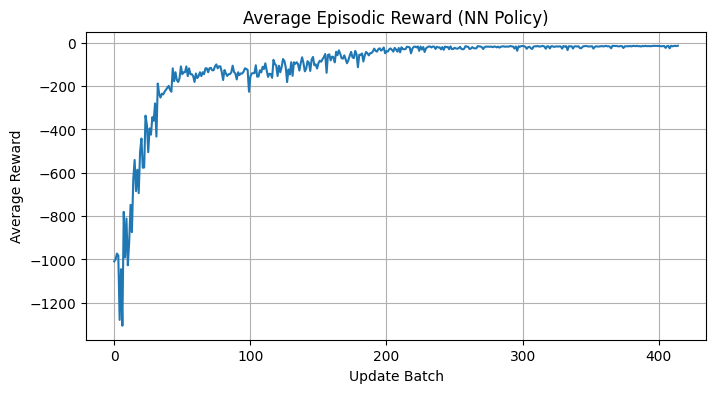

In [ ]:
#@title Plotting learning progress for the Reinforce Agent with NNPolicy.
plt.figure(figsize=(8, 4))
plt.plot(nn_avg_rewards)
plt.title("Average Episodic Reward (NN Policy)")
plt.xlabel("Update Batch")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

In [ ]:
#@title Watch your NN-based agent!

visualise_policy(
    policy=nn_agent.policy,
    max_episode_steps=500,
    folder="./videos_nn"
)

/tmp/ipython-input-29-125159748.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_tensor = torch.tensor(obs, dtype=torch.long)


### **Conclusion**

Congratulations! 🥳

You now have a solid foundation in policy gradient methods. From here, you can explore more advanced algorithms like **Actor-Critic (A2C)** and **Proximal Policy Optimization (PPO)**, which build upon the core ideas you've learned today to offer even better stability and performance. Happy learning!

# 🛠️ Practical 2 (Advanced): A2C and PPO

In this practical, we will learn about [Advantage Actor-Critic(A2C)](https://arxiv.org/abs/1602.01783) and [Proximal Policy Optimization (PPO)](https://arxiv.org/abs/1707.06347).

For this part, we will use the [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment.

**[CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/)** is a classic control task where the goal is to balance a pole upright on a moving cart. The agent observes a 4-dimensional continuous state (cart position, cart velocity, pole angle, and pole angular velocity) and chooses between 2 discrete actions: move the cart left or right. The episode ends when the pole falls past a certain angle, the cart moves out of bounds, or 500 time steps elapse. The agent receives a reward of +1 for each time step the pole remains balanced, with a maximum possible score of 500 per episode.


![cart-pole](https://gymnasium.farama.org/_images/cart_pole.gif)

In [ ]:
#@title Load the "CartPole" environment.

env = gym.make("CartPole-v1")
num_actions = env.action_space.n
input_dim = env.observation_space.shape[0]

print(f"Observation space (continuous): {env.observation_space.shape}")
print(f"Action space: {env.action_space}")

### Problems with REINFORCE
---

The REINFORCE algorithm has one major drawback: **high variance** in its gradient estimates.

Let's look at the update rule again. The policy gradient is scaled by the return $G_{i,t}$:
$$
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=0}^{T_i-1} \color{red}{G_{i,t}} \color{black}{\cdot \nabla_\theta \log \pi_\theta(a_{i,t} | s_{i,t})}
$$

This single scalar value, $G_{i,t}$, is used to credit every action from step $t$ onwards. This creates two problems related to what is known as **credit assignment**:

1.  **Good actions in a bad trajectory get penalized.** Imagine an agent takes one great action but then makes a series of blunders, leading to a low total return. The great action will still be discouraged because the overall outcome was poor.
2.  **Bad actions in a good trajectory get rewarded.** Conversely, a single lucky action at the end of an episode can result in a high return, causing all preceding actions (even poor ones) to be reinforced.

Because the Monte Carlo return $G_{i,t}$ is the sum of many potentially random events, it can fluctuate wildly from one episode to the next. This makes the learning signal very noisy. To overcome this noise, REINFORCE often requires a large number of samples (episodes), making it **sample inefficient**.

So, how can we create a more stable and reliable learning signal?

### Actor-Critic methods
---

The key idea is to change our perspective. Instead of judging an action by its raw return $G_t$, we ask a better question:

> How much better or worse was this return than what we *expected* to get from this state?

To answer this, we need to formalize the idea of "what we expected to get". This is precisely the job of the **state-value function**, denoted as $V(s)$. The value function $V^\pi(s)$ answers the question: "Starting from state $s$, what is the average total return I can expect to get if I follow my current policy $\pi$ from this point forward?"

Mathematically, it's defined as the **expected return, given the starting state**:
$$
V^\pi(s) = \mathbb{E}_{\pi}[G_t | S_t = s]
$$
In short, $V(s)$ is a measure of how "good" a state is. A state with a high value is promising because we expect to accumulate a lot of future reward from there.

With this concept, we have the perfect **baseline** for our calculation. We can compare the *actual* return $G_t$ we got with the *expected* return $V(s_t)$. This difference is called the **Advantage**.

$$
A(s_t, a_t) \approx G_t - V(s_t)
$$

The Advantage $A(s_t, a_t)$ tells us how much better taking action $a_t$ was compared to the average action from state $s_t$.
*   If $A(s_t, a_t) > 0$, the action led to a better-than-expected outcome.
*   If $A(s_t, a_t) < 0$, the action led to a worse-than-expected outcome.


This signal is much less noisy. A return of `+10` might be fantastic in a state where you expect `0` (Advantage = +10), but poor in a state where you expect `+20` (Advantage = -10). The Advantage centers the learning signal around zero, dramatically reducing variance and stabilizing training.

This leads us to **Actor-Critic** methods:
-   The **Actor** is the policy ($\pi_\theta$), which decides which action to take. It learns using the Advantage.
-   The **Critic** is the value function ($V_\phi$), which estimates the value of each state. Its job is to provide the baseline for the Actor's Advantage calculation.

Both the Actor and the Critic are neural networks with parameters $\theta$ and $\phi$, respectively, that we train simultaneously.

To train them, we combine their objectives into a single loss function:

1.  **Actor Loss ($L_{actor}$)**: This is the policy gradient loss, but using the Advantage instead of $G_t$. We want to maximize the log-probability of actions, scaled by their advantage. (Note: the negative sign is for gradient descent).

    $$L_{actor} = - \mathbb{E}[A(s_t, a_t) \cdot \log \pi_\theta(a_t|s_t)]$$

2.  **Critic Loss ($L_{critic}$)**: The Critic's job is to make its value estimate $V_\phi(s_t)$ as close as possible to the observed return $G_t$. This is a standard regression problem, so we use the Mean Squared Error.

    $$L_{critic} = \mathbb{E}[(G_t - V_\phi(s_t))^2]$$

The total loss we minimize is a weighted sum of the two.

### The Actor-Critic Policy
---

Our policy network now needs to produce 2 outputs from a single state:
1.  A probability distribution over actions (for the Actor).
2.  A single value estimating the quality of the state (for the Critic).

A common and effective architecture is to use a shared "body" network that processes the observation, followed by two separate "heads" for the policy and value outputs. This allows the network to learn a common representation of the state that is useful for both tasks.

#### ✏️ **Exercise: Implement an Actor-Critic NN Policy**

Complete the architecture of the `NN_Policy_Value` class below. Since we are using `CartPole-v1`, the observation is a 4-dimensional vector representing (cart position, cart velocity, pole angle, and pole angular velocity).

<details>
<summary>💡 Hints</summary>

*   The shared body can be an `nn.Sequential` that contains an `nn.Linear(input_dim, hidden_size)` layer followed by an `nn.ReLU()`.

*   The policy head (the actor) is a separate `nn.Linear` layer that maps the `hidden_size` features to `num_actions`.

*   The value head (the critic) is another `nn.Linear` layer that maps the `hidden_size` features to a single output of size 1.

</details>

In [ ]:
class NN_Policy_Value(nn.Module):
    """
    An actor-critic policy network with a shared body and separate heads.
    """
    def __init__(
        self,
        input_dim: int,  # this will be `env.observation_space.shape`
        num_actions: int,
    ):
        super().__init__()

        ################################################################
        # Your solution:
        # 1. Define the shared network body.
        # self.hidden_body = ...

        # 2. Define the policy head for the Actor.
        # self.policy_head = ...

        # 3. Define the value head for the Critic.
        # self.value_head = ...
        ################################################################

    def forward(self, obs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Performs the forward pass.

        Args:
            obs: A tensor of state indices.

        Returns:
            A tuple containing:
            - torch.Tensor: Action logits from the policy head.
            - torch.Tensor: The state value from the value head.
        """
        # First, one-hot encode the discrete state observation.
        if obs.dim() == 0:  # Handle single integer observation.
            obs = obs.unsqueeze(0)

        # Pass through the shared body.
        hidden_features = self.hidden_body(obs)

        # Get action logits and state value from the heads.
        action_logits = self.policy_head(hidden_features)  # [B, num_actions].
        state_value = self.value_head(hidden_features)  # [B, 1].

        return action_logits, state_value

### The A2C (Advantage Actor-Critic) Agent
---

Let's build the `A2CAgent` agent.

For the policy gradient loss, use the Advantage instead of $G_t$. For learning the state-value function $V_\phi(s_t)$, we apply a Mean Squared Error to bring it closer to the observed return $G_t$. The total loss we minimize is their (weighted) sum.

$$Loss_{A2C} = -\mathbb{E}[A(s_t, a_t) \cdot \log \pi_\theta(a_t|s_t)] + \alpha * \mathbb{E}[(G_t - V_\phi(s_t))^2]$$

where $\alpha$ is the weight of the value loss.



#### ✏️ **Exercise: Implement the A2C Loss**

Complete the `update` method in the `A2CAgent` below.


<details>
<summary>💡 Hints</summary>

*   The advantage is the difference between the actual `returns` and the critic's predicted `values`.

*   The policy loss is the negative mean of `log_probs` multiplied by the `advantage`. Use `advantage.detach()` to stop gradients from flowing back into the value network from this loss.

*  The value loss measures the critic's prediction error. Use `F.mse_loss()` to calculate the mean squared error between the `values` and `returns`.

*   The final loss is the `policy_loss` plus the `value_loss` scaled by `self._value_loss_weight`.

</details>

In [ ]:
class A2CAgent(ReinforceAgent):
    """Implements the Advantage Actor-Critic (A2C) algorithm."""

    def __init__(self, policy: NN_Policy_Value, gamma: float = 0.99, value_loss_weight: float = 0.5):
        super().__init__(policy=policy, gamma=gamma)
        self._value_loss_weight = value_loss_weight

    def forward(self, obs: torch.Tensor) -> tuple[int, torch.Tensor, torch.Tensor]:
        """Selects an action, its log-probability, and the state value."""
        action_logits, value = self.policy(obs)
        distribution = Categorical(logits=action_logits)
        action = distribution.sample()
        log_prob = distribution.log_prob(action)
        return action.item(), log_prob, value.squeeze(-1)

    def update(self, batch_data: dict, optimizer: torch.optim.Optimizer):
        """Performs the learning step for a batch of episodes."""
        # Unpack data for the whole batch, collected by the training loop
        log_probs = torch.cat(batch_data['log_probs'])
        values = torch.cat(batch_data['values'])
        returns = torch.cat(batch_data['returns'])

        ################################################################
        # Your solution:
        # 1. Calculate the advantage.
        # advantage = ...

        # 2. Calculate the policy loss (actor loss).
        # We use .mean() for stability across batch sizes.
        # policy_loss = ...

        # 3. Calculate the value loss (critic loss).
        # value_loss = ...

        # 4. Combine the losses.
        # loss = ...
        ################################################################

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Improving A2C with Entropy Regularization

A common problem in RL is an agent that becomes too confident in a sub-optimal policy too early, failing to explore other, potentially better options. To encourage exploration, we can add an **entropy bonus** to our loss function.

**Entropy** is a measure of randomness or uncertainty in a probability distribution. A high-entropy policy is more random (exploratory), while a low-entropy policy is more deterministic (exploitative).

By adding the policy's entropy to the objective (or subtracting it from the loss), we encourage the agent to maintain a degree of randomness, preventing it from collapsing into a single, greedy action too soon.

$$ \text{Loss}_{final} = \text{Loss}_{A2C} - \beta \cdot H(\pi_\theta(s_t)) $$

where `H` is the entropy and `β` is a small coefficient to weigh the entropy bonus.

#### ✏️ **Exercise: Implement the Entropy Bonus**

We can implement this by creating a new agent that inherits from `A2CAgent` and overrides the `update` method.


<details>
<summary>💡 Hints</summary>

*   To calculate entropy for the batch, you first need to get the action distributions for all `states` that were visited. Pass the `states` tensor through `self.policy` to get the logits.

*   Create a `Categorical` distribution from the logits. This distribution object has a built-in `.entropy()` method.

*   Call `.entropy().mean()` on your distribution to get the average entropy for the batch.

*   The final loss is `policy_loss + value_loss - (entropy_weight * entropy)`. We subtract the entropy term because maximizing entropy is equivalent to minimizing negative entropy.

</details>

In [ ]:
class A2CEntropyAgent(A2CAgent):
    """Implements A2C with an entropy bonus for exploration."""

    def __init__(
        self,
        policy: NN_Policy_Value,
        value_loss_weight: float = 0.5,
        entropy_weight: float = 0.01,
    ):
        super().__init__(policy, value_loss_weight=value_loss_weight)
        self._entropy_weight = entropy_weight

    def update(self, batch_data: dict, optimizer: torch.optim.Optimizer):
        """Performs the learning step, adding an entropy bonus."""
        log_probs = torch.cat(batch_data['log_probs'])
        values = torch.cat(batch_data['values'])
        returns = torch.cat(batch_data['returns'])
        states = torch.cat(batch_data['states'])

        advantage = returns - values
        policy_loss = -(log_probs * advantage.detach()).mean()
        value_loss = F.mse_loss(values, returns)

        ################################################################
        # Your solution:
        # 1. Get the action logits for all visited states to compute entropy.
        # logits, _ = ...

        # 2. Calculate the entropy bonus.
        # entropy_bonus = ...

        # 3. Combine the losses, including the entropy bonus.
        # loss = ...
        ################################################################

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Stabilizing with PPO (Proximal Policy Optimization)

Even with advantage estimation and entropy bonus, policy gradient methods can be unstable. A single bad update step can drastically change the policy, leading to a performance collapse that is difficult to recover from.

**PPO** introduces a simple idea to prevent this: it constrains how much the new policy can differ from the old one at each update. It achieves this by "clipping" the objective function.

The core idea is to use a ratio:

$$w_t(\theta) = \pi_\theta(a_t|s_t) / \pi_{\theta_{old}}(a_t|s_t)$$

that measures how much the probability of an action has changed.

The PPO loss then takes the minimum of the normal objective and a "clipped" version:

$$ L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min(w_t(\theta) \hat{A}_t, \text{clip}(w_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t) \right] $$

This clipping prevents the policy from changing too aggressively, especially when the advantage is large, leading to more stable training.

> PPO is still a state-of-the-art algorithm used widely today.


#### ✏️ **Exercise 4: Implement the PPO Loss**

We will provide the boilerplate for the PPO update loop, which often involves multiple optimization steps on the same batch of data.

Your task is to implement the policy loss.

<details>
<summary>💡 Hints</summary>

*   1. The probability ratio `w_t` is calculated in log space for numerical stability. Use `torch.exp(new_log_probs - old_log_probs)`.

*   2. For the first surrogate objective (`surr1`), simply multiply the ratio `w_t` by the `advantages`.

*   2. For the second surrogate objective (`surr2`), first clip the ratio `w_t` using `torch.clamp()`. The min and max values for the clamp are `1 - self._clip_epsilon` and `1 + self._clip_epsilon`. Then multiply the result by the `advantages`.

*   3. The PPO policy loss takes the element-wise minimum of `surr1` and `surr2`. Use `torch.min()` for this, then take the `.mean()`, and remember to negate the final result.

*   4. Add the value loss (mean squared error with returns) as before.

</details>

In [ ]:
class PPOAgent(A2CEntropyAgent):
    """Implements the Proximal Policy Optimization (PPO) algorithm."""

    def __init__(
        self,
        policy: NN_Policy_Value,
        value_loss_weight: float = 0.5,
        entropy_weight: float = 0.01,
        clip_epsilon: float = 0.2,
        n_epochs: int = 4,
    ):
        super().__init__(
            policy=policy,
            value_loss_weight=value_loss_weight,
            entropy_weight=entropy_weight,
        )
        self._clip_epsilon = clip_epsilon
        self._n_epochs = n_epochs

    def update(self, batch_data: dict, optimizer: torch.optim.Optimizer):
        """Performs the PPO update over multiple epochs."""
        # PPO uses the collected data multiple times, so we detach it.
        old_log_probs = torch.cat(batch_data['log_probs']).detach()
        old_values = torch.cat(batch_data['values']).detach()
        returns = torch.cat(batch_data['returns']).detach()
        states = torch.cat(batch_data['states']).detach()
        actions = torch.tensor(sum(batch_data['actions'], [])).detach()

        # Calculate advantages once using old values and normalize them.
        advantages = returns - old_values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # --- PPO Inner Loop ---
        for _ in range(self._n_epochs):
            # Get new predictions from the current (updated) policy.
            new_logits, new_values = self.policy(states)
            new_values = new_values.squeeze(-1)
            distribution = Categorical(logits=new_logits)
            new_log_probs = distribution.log_prob(actions)

            ################################################################
            # Your solution:
            # 1. Calculate the importance sampling weights.
            # w_t = ...

            # 2. Calculate the two surrogate objectives.
            # surr1 = ...
            # surr2 = ...

            # 3. Put together the PPO policy loss based on the two surrogates.
            # policy_loss = ...

            # 4. Value loss.
            # value_loss = ...
            ################################################################

            # Entropy bonus.
            entropy_bonus = distribution.entropy().mean()

            loss = (
                policy_loss
                + self._value_loss_weight * value_loss
                - self._entropy_weight * entropy_bonus
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

Finally, let's adapt our `train_agent` function from Practical 1 to handle the Actor-Critic agents. The main change is handling the "bootstrapped" value from the final state if an episode is truncated.

In [ ]:
# @title Training loop for Actor-Critic agents.

def train_actor_critic_agent(
    env: gym.Env,
    agent: A2CAgent,
    optimizer: torch.optim.Optimizer,
    num_updates: int,
    episodes_per_batch: int,
    max_episode_steps: int,
    convergence_threshold: float,
    log_frequency: int = 20
):
    """A generic function to train Actor-Critic style agents."""
    avg_rewards_history = []
    print(f"Starting training for {agent.__class__.__name__}...")

    pbar = tqdm(range(num_updates), mininterval=2)
    for i in pbar:
        batch_data = {  # this is to hold all data for the batch.
            'states': [], 'actions': [], 'rewards': [],
            'log_probs': [], 'values': [], 'returns': []
        }
        batch_total_rewards = []

        # --- Data Collection Phase ---
        for _ in range(episodes_per_batch):
            # Per-episode storage
            episode_states, episode_actions, episode_rewards = [], [], []
            episode_log_probs, episode_values = [], []
            episode_total_reward = 0
            state, _ = env.reset()

            for step in range(max_episode_steps):
                state_tensor = torch.tensor(state)
                # Get action, log_prob, and value from the agent.
                action, log_prob, value = agent(state_tensor)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                # Store experience.
                episode_states.append(state_tensor)
                episode_actions.append(action)
                episode_rewards.append(reward)
                episode_log_probs.append(log_prob)
                episode_values.append(value)
                episode_total_reward += reward
                state = next_state

                if done:
                    break

            # --- Episode Finish: Calculate Returns and Bootstrap ---
            last_value = 0.0
            if truncated: # bootstrap if episode was cut short.
                with torch.no_grad():
                    _, last_value_tensor = agent.policy(torch.tensor(state))
                    last_value = last_value_tensor.item()

            # Calculate discounted returns for the episode.
            returns = []
            R = last_value
            for r in reversed(episode_rewards):
                R = r + agent.gamma * R
                returns.insert(0, R)

            # Add this episode's data to the batch.
            batch_data['states'].append(torch.stack(episode_states))
            batch_data['actions'].append(episode_actions)
            batch_data['rewards'].append(episode_rewards)
            batch_data['log_probs'].append(torch.stack(episode_log_probs))
            batch_data['values'].append(torch.stack(episode_values))
            batch_data['returns'].append(torch.tensor(returns, dtype=torch.float32))
            batch_total_rewards.append(episode_total_reward)

        # --- Learning Phase ---
        agent.update(batch_data, optimizer)

        # --- Logging ---
        avg_reward_for_batch = np.mean(batch_total_rewards)
        avg_rewards_history.append(avg_reward_for_batch)
        pbar.set_postfix(avg_reward=f"{avg_reward_for_batch:.2f}")

        # Check for convergence.
        if avg_reward_for_batch > convergence_threshold:
            print(f"\nSolved at update {i}!")
            break

    return avg_rewards_history

In [ ]:
# --- Hyperparameters ---
LEARNING_RATE = 0.01
NUM_UPDATES = 1000
EPISODES_PER_BATCH = 10
MAX_EPISODE_STEPS = 500

VALUE_WEIGHT_LOSS = 0.5  # for A2C
ENTROPY_WEIGHT = 0.01  # for A2C with regularization
CLIP_EPSILON = 0.2  # for PPO only
N_EPOCHS = 4  # for PPO only

# --- Agent Selection ---
agent_to_train = "A2CEntropy" # @param ["A2C", "A2CEntropy", "PPO"]

# --- Initialization ---
# We use the same policy network for all agents
policy = NN_Policy_Value(input_dim=input_dim, num_actions=num_actions)

if agent_to_train == "A2C":
    agent = A2CAgent(
        policy=policy,
        value_loss_weight=VALUE_WEIGHT_LOSS,
    )
elif agent_to_train == "A2CEntropy":
    agent = A2CEntropyAgent(
        policy=policy,
        value_loss_weight=VALUE_WEIGHT_LOSS,
        entropy_weight=ENTROPY_WEIGHT,
    )
elif agent_to_train == "PPO":
    agent = PPOAgent(
        policy=policy,
        value_loss_weight=VALUE_WEIGHT_LOSS,
        entropy_weight=ENTROPY_WEIGHT,
        clip_epsilon=CLIP_EPSILON,
        n_epochs=N_EPOCHS,
    )
else:
    raise ValueError(f'Unknown agent {agent_to_train}.')

optimizer = optim.Adam(policy.parameters(), lr=LEARNING_RATE)

# --- Run Training ---

avg_rewards = train_actor_critic_agent(
    env=env,
    agent=agent,
    optimizer=optimizer,
    num_updates=NUM_UPDATES,
    episodes_per_batch=EPISODES_PER_BATCH,
    max_episode_steps=MAX_EPISODE_STEPS,
    convergence_threshold=500,
    log_frequency=50
)

In [ ]:
#@title Plotting Episodic Rewards

plt.figure(figsize=(8, 4))
plt.plot(avg_rewards)
plt.title(f"Learning curve for {agent.__class__.__name__}")
plt.xlabel("Update Batch")
plt.ylabel("Average Reward per Batch")
plt.grid(True)
# Add a line for the optimal score.
plt.axhline(y=-13, color='r', linestyle='--', label='Optimal Score (-13)')
plt.legend()
plt.show()

In [ ]:
#@title Visualize the trained Agent.

# We re-use the visualise_policy function from Practical 1.
visualise_policy(
    env_id='CartPole-v1',
    policy=agent.policy,
    max_episode_steps=500,
)

# 🛠️ Practical 3: Fine-tuning a language model

We have journeyed from simple tabular policies to neural networks solving classic control problems. Now, we'll scale up dramatically to one of the most exciting applications of RL today: fine-tuning Large Language Models (LLMs).

You've likely heard of models like ChatGPT, Claude, Gemini and Llama. A key reason for their success is a process called **Reinforcement Learning from Human Feedback (RLHF)**.

#### Mapping RL Concepts to LLMs

Let's connect this back to what we've learned. How do our RL concepts apply here?

-   🧠 **Policy**: The LLM (GPT-2) is our policy. Its parameters are the weights of the neural network.
-   ✍️ **Action**: The "action" is the generation of the next token from the entire vocabulary. A full response is a sequence of actions.
-   📄 **State**: The "state" is the sequence of tokens generated so far. It starts with the input prompt and grows with each token the policy generates.
-   👍 **Reward**: The score given to the final, complete response by our reward model (the sentiment classifier).


#### Why do we need RL for LLMs?

Standard LLMs are trained to predict the next word in a massive dataset of text from the internet. This makes them excellent at mimicking human language, but it doesn't guarantee they are helpful, harmless, or follow instructions well. This is known as the **alignment problem**.

RLHF is a technique to "steer" an already pre-trained LLM towards desired behaviors (like being more helpful, positive, or concise).

The full RLHF process has three main steps:
1.  **Pre-training an LLM**: This is the standard language modeling step (already done for us).
2.  **Training a Reward Model (RM)**: A separate model is trained to predict which of two responses a human would prefer. This RM learns to score text based on human values.
3.  **Fine-tuning with RL**: The pre-trained LLM (the policy) is then fine-tuned using RL. It generates text, the Reward Model scores it, and an RL algorithm (like PPO) updates the LLM's weights to maximize the reward.

For this tutorial, we will implement a simplified version of this pipeline called **Reinforcement Learning from Classifier Feedback**. Instead of training our own reward model on human preferences, we will use a pre-trained sentiment **classifier** as our reward model. Our goal: to tune GPT-2 to generate more positive movie reviews.

#### From REINFORCE to PPO

For a complex task like language generation, the high variance of the REINFORCE algorithm can make training unstable. We'll use a more advanced and robust algorithm from the same policy gradient family: **Proximal Policy Optimization (PPO)**.

> **Intuition for PPO**: You can think of PPO as a smarter, more stable version of REINFORCE. It also updates the policy based on rewards, but it constrains how much the policy can change in each update step (compared to the previous policy), preventing it from straying too far from what it already knows. This leads to much smoother training.

We will use the [trl](https://github.com/huggingface/trl) library from Hugging Face, which handles the complexity of PPO for us.

## GPT2 for positive reviews

Let's fine-tune a pre-trained GPT-2 to generate positive continuations for movie review prompts. We'll use:
*   **Policy**: A GPT-2 model fine-tuned on the IMDB dataset, called [lvwerra/gpt2-imdb](https://huggingface.co/lvwerra/gpt2-imdb) with 124M parameters.
*   **Reward Model**: A DistilBERT model pre-trained on the sentiment analysis task: it has been trained to predict whether the text is positive or negative -- this has 66M parameters.

**N.B.** This section is based on (now deprecated) [Tune GPT2 to generate positive reviews](https://huggingface.co/docs/trl/v0.1.1/en/sentiment_tuning).

In [ ]:
# Set up the device and a separate device for the reward pipeline.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe_device = 0 if torch.cuda.is_available() else -1

#### Configuration

First, let's set up our environment and all the hyperparameters for our experiment:
-  `config` for fine-tuning the pretrained LLM model using PPO
- `sent_kwargs` for the reward (sentiment analysis) model
- `gen_kwargs` for generating data with the LLM, which can be considered as gathering the trajectories by sampling actions from the agent's policy.

In [ ]:
# PPO Configuration.
config = {
    "model_name": "lvwerra/gpt2-imdb",
    "steps": 20000,
    "batch_size": 256,
    "txt_in_min_len": 2,
    "txt_in_max_len": 8,
    "txt_out_min_len": 4,
    "txt_out_max_len": 16,
    "lr": 1.41e-5,
    "init_kl_coef": 0.2,
    "target": 6,
}

# Generation settings for the LLM.
gen_kwargs = {
    "min_length":-1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": None,
}

# Reward model settings.
sent_kwargs = {
    "top_k": None,
    "function_to_apply": "none",
    "batch_size": 16,
}

#### Load data

We'll load the IMDB dataset, which contains movie reviews. These reviews will serve as the initial "state" or "prompt" for our GPT-2 model.

In [ ]:
ds = load_dataset('imdb', split='train')
ds = ds.rename_columns({'text': 'review', 'label': 'sentiment'})
# Filter out very short reviews.
ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

#### Load the reward model.

Next, we'll load our reward model (the sentiment classifier). This pipeline will take a piece of text and return a score for "positive" and "negative" sentiment. We'll use the "positive" score as our reward signal.

In [ ]:
sentiment_pipe = pipeline("sentiment-analysis","lvwerra/distilbert-imdb", device=pipe_device)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Let's test the reward pipeline -- feel free to try out your own examples!

example_texts = [
    "This movie was absolutely fantastic, a must-see!",
    "I was so bored I fell asleep in the theater."
]

rewards = []
outputs = sentiment_pipe(example_texts, top_k=None)

for output in outputs:
    positive_score = output[1]['score']
    rewards.append(positive_score)

for example_text, reward in zip(example_texts, rewards):
  print(f"Text: '{example_text}'\nReward: {reward:.4f}\n")

Text: 'This movie was absolutely fantastic, a must-see!'
Reward: 0.0046

Text: 'I was so bored I fell asleep in the theater.'
Reward: 0.0040



#### Load policy model

Now, we load our policy model (GPT-2). We need 2 copies:

*  `gpt2_model`: This is the policy we will actively train and update.
*  `gpt2_model_ref`: This is a frozen, non-trainable copy. PPO uses this reference to calculate the KL divergence penalty, ensuring our active policy doesn't stray too far from its original behavior.

The `AutoModelForCausalLMWithValueHead` class from `trl` is a special wrapper that adds an extra "value head" to the standard GPT-2 model. This value head is trained to predict the expected reward from a given state, which is a key component of PPO's optimization process.

In [ ]:
gpt2_model = AutoModelForCausalLMWithValueHead.from_pretrained(config['model_name'])
gpt2_model_ref = AutoModelForCausalLMWithValueHead.from_pretrained(config['model_name'])
gpt2_tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

# Set the pad token to the end-of-sequence token.
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gen_kwargs["pad_token_id"] = gpt2_tokenizer.pad_token_id

gpt2_model.to(device);
gpt2_model_ref.to(device);

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

#### Pre-process Data and Initialize PPO

We need to prepare the data for the `PPOTrainer`. We will tokenize the prompts from our dataset. To make training more robust, we'll use `LengthSampler` to generate prompts and responses of varying lengths.

In [ ]:
class LengthSampler:
    def __init__(self, min_value, max_value):
        self.values = list(range(min_value, max_value))
    def __call__(self):
        return np.random.choice(self.values)

# Sampler for dynamic query and response lengths
input_size = LengthSampler(config['txt_in_min_len'], config['txt_in_max_len'])
output_size = LengthSampler(config['txt_out_min_len'], config['txt_out_max_len'])

In [ ]:
def tokenize(sample):
    sample["tokens"] = gpt2_tokenizer.encode(sample["review"])[:input_size()]
    sample["query"] = gpt2_tokenizer.decode(sample["tokens"])
    return sample

ds = ds.map(tokenize, batched=False)

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

dataloader = torch.utils.data.DataLoader(ds, batch_size=config['batch_size'], collate_fn=collator)

Finally, we initialize the `PPOTrainer`. This powerful class from `trl` orchestrates the entire fine-tuning process. We pass it our models, tokenizer, and the PPO configuration we defined earlier.

In [ ]:
ppo_config = PPOConfig(batch_size=config['batch_size'], mini_batch_size=16)
ppo_trainer = PPOTrainer(ppo_config, gpt2_model, gpt2_model_ref, gpt2_tokenizer)

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:193: FutureWarning: `PPOTrainer` is deprecated and will be removed in trl v0.12. Please use `PPOv2Trainer` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_trainer.py:273: UserWarning: No dataset is provided. Make sure to set config.batch_size to the correct value before training.
  warnings.warn(


### The Fine-tuning Loop
---

The training loop is where the magic happens. For each batch of prompts, we perform a three-step process:
1.  **Get Responses**: Use the policy model (`gpt2_model`) to generate completions for the prompts.
2.  **Get Rewards**: Use the sentiment classifier (`sentiment_pipe`) to score the completions.
3.  **Optimize**: Feed the prompts, responses, and rewards into the `ppo_trainer` to update the policy model's weights.

#### ✏️ **Exercise: Implement the PPO training step!**

Complete the code in the cell below. You'll need to implement the three steps described above.

<details><summary>💡 Hints</summary>

1.  **Generate Responses**:
    *   The `query_tensors` (the tokenized prompts) are already prepared for you.
    *   You need to loop through them and use `gpt2_model.generate()` to create a response for each one.
    *   Remember to use a random `output_size()` for each generation and pass the `gen_kwargs`.
    *   The generated output from the model includes the prompt, so you'll need to slice it to get only the new tokens (the response). The length of the response is `gen_len`.

2.  **Calculate Rewards**:
    *   The reward is calculated on the full text (`query + response`). You'll need to create a list of these full texts.
    *   Pass this list to the `sentiment_pipe`.
    *   The output of the pipeline is a list of dictionaries. For each output, you want the score for the 'POSITIVE' label. In our case, the pipeline returns `[{'label': 'NEGATIVE', 'score': ...}, {'label': 'POSITIVE', 'score': ...}]`, so you'll want `output[1]["score"]`.
    *   Make sure your final `rewards` are a list of PyTorch tensors.

3.  **Perform PPO Step**:
    *   The final step is easy! Just call `ppo_trainer.step()` and pass it the `query_tensors`, `response_tensors`, and `rewards` you prepared.

</details>

In [ ]:
# Set the number of epochs for fine-tuning.
# A few epochs are enough to see a change.
MAX_NUM_EPOCHS = 5  # @ param

total_ppo_epochs = int(np.ceil(config['steps'] / config['batch_size']))


for epoch, batch in tqdm(zip(range(total_ppo_epochs), iter(dataloader))):
  ################################################################
  # Fine-tune GPT2 using the pre-trained distilbert-imdb as the reward function.
  # Your solution:
  # Get the query tensors using batch['tokens'].
  # query_tensors = ...

  # Get response from gpt2
  # response_tensors = []
  # for i in range(config['batch_size']):
  # Use gpt2_model.generate() to get the responses.
  # response = ...
  # response_tensors.append(...)
  # batch['response'] = [gpt2_tokenizer.decode(r.squeeze()) for r in response_tensors]

  # Compute sentiment score, concatenating batch['query'] and batch['response']
  # to build the input for sentiment_pipe.
  # ...
  # rewards = ...

  # Run PPO step.
  # stats = ppo_trainer.step(...)
  ################################################################
  logs, timing = dict(), dict()
  query_tensors = [torch.tensor(t).long().to(device) for t in batch['tokens']]

  # Get response from gpt2.
  response_tensors = []
  for i in range(config['batch_size']):
    gen_len = output_size()
    ################################################################
    # response = ...
    ################################################################
    response_tensors.append(response.squeeze()[-gen_len:])
  batch['response'] = [
      gpt2_tokenizer.decode(r.squeeze()) for r in response_tensors
  ]

  # Compute sentiment score.
  texts = [q + r for q, r in zip(batch['query'], batch['response'])]
  ################################################################
  # pipe_outputs = ...
  ################################################################
  rewards = [
      torch.tensor(output[1]['score']).to(device) for output in pipe_outputs
  ]

  # Run PPO step.
  ################################################################
  # stats = ...
  ################################################################
  rewards = torch.tensor(rewards).to(device)

  table_rows = [
      list(r)
      for r in zip(batch['query'], batch['response'], rewards.cpu().tolist())
  ]
  logs.update(timing)
  logs.update(stats)
  logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
  logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
  logs['env/reward_dist'] = rewards.cpu().numpy()

  if epoch == MAX_NUM_EPOCHS:
    break

#### Evaluate the Results

Now, let's see if our fine-tuning worked! We will take a sample of prompts and generate responses from both the original model (`gpt2_model_ref`) and our fine-tuned model (`gpt2_model`). We can then compare them qualitatively by reading them, and quantitatively by checking their average reward scores.

In [ ]:
# Get a batch from the dataset.
bs = 16  # a batch size
game_data = dict()
ds.set_format('pandas')
df_batch = ds[:].sample(bs)
game_data['query'] = df_batch['query'].tolist()
query_tensors = df_batch['tokens'].tolist()

response_tensors_ref, response_tensors = [], []

# Get response from `gpt2` and `gpt2_ref`.
for i in range(bs):
  gen_len = output_size()
  output = gpt2_model_ref.generate(
      torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
      max_new_tokens=gen_len,
      **gen_kwargs,
  ).squeeze()[-gen_len:]
  response_tensors_ref.append(output)
  output = gpt2_model.generate(
      torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
      max_new_tokens=gen_len,
      **gen_kwargs,
  ).squeeze()[-gen_len:]
  response_tensors.append(output)

# Decode responses.
game_data['response (before)'] = [
    gpt2_tokenizer.decode(response_tensors_ref[i]) for i in range(bs)
]
game_data['response (after)'] = [
    gpt2_tokenizer.decode(response_tensors[i]) for i in range(bs)
]

# Sentiment analysis of query/response pairs before/after.
texts = [
    q + r for q, r in zip(game_data['query'], game_data['response (before)'])
]
game_data['rewards (before)'] = [
    output[1]['score'] for output in sentiment_pipe(texts, **sent_kwargs)
]

texts = [
    q + r for q, r in zip(game_data['query'], game_data['response (after)'])
]
game_data['rewards (after)'] = [
    output[1]['score'] for output in sentiment_pipe(texts, **sent_kwargs)
]

# Store results in a dataframe.
df_results = pd.DataFrame(game_data)
df_results.head()

In [ ]:
print('Mean:')
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print('Median:')
display(df_results[["rewards (before)", "rewards (after)"]].median())

You should see a noticeable increase in the average reward, even after fine-tuning for just a few epochs! When you look at the generated text, you'll likely see that the "after" responses are more consistently positive in tone.

This demonstrates the core loop of RLHF: **generate, reward, and optimize**. You've successfully steered an LLM's behavior using a reward signal, bridging the gap from simple RL problems to the cutting edge of AI alignment.

Feel free to experiment with different reward functions or different LLMs! 😀

## Beyond Classifiers: A Spectrum of Feedback

In our practical exercise, we used a pre-trained sentiment classifier to provide a reward signal. This is an example of machine feedback, but it's just one point on a wide spectrum of methods used to score LLM responses.

### **🧑‍⚖️ RLHF: Human Feedback**

This is the "gold standard" for capturing nuanced, subjective, and value-laden concepts that are difficult to define with rules.

**How it Works**: The process focuses on learning preferences.
1.  A prompt is given to the LLM, which generates two or more different responses (e.g., Response A, Response B).
2.  A human labeler reads the prompt and the responses and indicates which one they prefer (e.g., `A` is better than `B`).
3.  This process is repeated thousands of times, creating a large dataset of human preferences.
4.  A separate reward model (RM) is trained on this dataset to predict which response a human would prefer. The RM learns to output a scalar score (a reward) that reflects this preference.

**Where it Excels**:
-   **Subjectivity & Style**: Teaching an AI to be funny, poetic, or empathetic.
-   **Helpfulness & Harmlessness**: Aligning models with complex human values that go beyond simple right/wrong answers.
-   **Summarization**: Creating summaries that are not just factually correct but also intuitive and easy to understand.

### **🤖 RLMF: Machine Feedback**

This is the method we used in our tutorial. The reward signal comes from an automated, objective, and verifiable source.

**How it Works**: The reward function is an explicit program or model that checks for correctness based on predefined rules.
    -   A sentiment classifier checks for positive language.
    -   A unit test suite checks if generated code compiles and runs correctly.
    -   A validator checks if the output conforms to a specific format (e.g., valid JSON).

**Where it Excels**:
-   **Coding**: The reward can be `+1` if the code passes all unit tests, and `0` otherwise.
-   **Mathematics**: The reward is high if the model's final answer matches the correct solution.
-   **Structured Data Generation**: The reward is high if the output is a perfectly formatted JSON object or XML file.

### **📜 RLAIF: AI Feedback**

This approach aims to solve the biggest bottleneck of RLHF: the time and cost of collecting human feedback. Instead of humans, it uses a powerful "critic" LLM to provide the preference labels.

**How it Works**: This is the core idea behind **Constitutional AI**, pioneered by Anthropic.
1.  A "constitution" is written. This is a set of principles and rules for the desired AI behavior (e.g., "Choose the response that is more helpful and less harmful," "Avoid manipulative or toxic language").
2.  The LLM generates two responses (A and B) to a prompt.
3.  A powerful, separate "critic" LLM is prompted to evaluate both responses *according to the constitution* and explain which one is better.
4.  This creates an AI-generated preference label (`A > B`), which is then used to train a Reward Model, just as human labels would be.

**Where it Excels**:
-   **Scalability**: Drastically reduces the need for human labelers, allowing for much larger preference datasets.
-   **Safety & Ethics**: Excellent for enforcing explicit ethical principles and reducing harmful, toxic, or biased outputs at scale.
-   **Transparency**: The reasoning for a preference is tied back to an explicit principle in the constitution.

| Feedback Type      | Reward Source                                     | Pros                                                 | Excels In                                             |
| ------------------ | ------------------------------------------------- | ---------------------------------------------------- | ----------------------------------------------------- |
| RL**H**F   | Human preference labels                           | Great for nuance, values, and quality | Subjective style, creativity, harmlessness |
| RL**M**F | A program, classifier, or set of rules           | Objective, fast, cheap, and verifiable            | Coding, math, structured data formatting             |
| RL**AI**F     | An LLM "critic" guided by a constitution         | Scalable, enforces explicit principles       | Safety alignment, reducing toxicity, ethical scaling |

## Beyond PPO: other RL algorithms for LLMs

We used PPO, a powerful and trusted algorithm from the `trl` library. However, the field is moving at an incredible pace, and researchers are constantly developing simpler, more efficient, and more stable alternatives to PPO. Here are a few of the most important recent developments.

### **🎯 DPO** (Direct Preference Optimization)

DPO has rapidly become a popular alternative to PPO due to its simplicity and stability. It was a breakthrough that showed you don't actually need an explicit, separately trained reward model.

**Core Idea**: DPO cleverly reframes the problem. Instead of the two-stage process of "1. Train a Reward Model, then 2. Use RL to satisfy it," DPO directly fine-tunes the policy on the preference data itself. It uses a loss function that directly increases the probability of preferred responses and decreases the probability of dispreferred ones, while a KL-divergence term keeps the policy from straying too far from a reference model.

**Why It's a Big Deal**:
-   **Simpler**: It completely eliminates the need to train, store, and run inference with a separate reward model, cutting the complexity of the RLHF pipeline in half.
-   **More Stable**: It avoids the common RL problem where the policy finds an exploit in a flawed reward model. By training directly on preferences, it's more robust.

**Further Reading**: [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290)


### **🎲 RLOO** (REINFORCE Leave-One-Out)

This algorithm goes "back to basics," showing that the simple REINFORCE algorithm we learned earlier can be made powerful enough for modern LLMs with a clever trick.

**Core Idea**: The main weakness of vanilla REINFORCE is the high variance of its reward signal. RLOO tackles this by creating a much better baseline for calculating the advantage. For a given prompt, it generates *multiple* responses. To calculate the advantage for any single response, it uses the average reward of **all other "sibling" responses** as a baseline. A response is only positively reinforced if it's better than the average of its peers generated from the same prompt.

**Why It's a Big Deal**: It makes the simple and elegant REINFORCE algorithm viable for LLM fine-tuning. It's much simpler to implement than PPO because it doesn't require a separate critic/value function network, yet it achieves competitive performance by drastically reducing variance.

**Further Reading**: [Back to Basics: Revisiting REINFORCE-Style Optimization for Learning from Human Feedback in LLMs](https://arxiv.org/abs/2402.14740)


### **🏅 GRPO** (Group Relative Policy Optimization)

Developed for the high-performing **DeepSeek-Math** model, GRPO is a specialized algorithm designed for tasks where there can be multiple correct solutions of varying quality, such as mathematical reasoning.

**Core Idea**: GRPO generalizes DPO from handling a *pair* of responses to handling a *group* of ranked responses. For a single math problem, the model might generate several different potential solutions. These solutions are then scored by a verifier (e.g., a Python interpreter that checks the final answer). GRPO's loss function then trains the policy to understand the *relative ranking* of the entire group—it learns to assign a higher probability to the best solution than the second-best, a higher probability to the second-best than the third-best, and so on.

**Why It's a Big Deal**: It is extremely effective for complex reasoning tasks. By generating and learning from a diverse group of candidate solutions, the model is more likely to discover a correct pathway. GRPO then efficiently extracts the maximum amount of learning signal from this entire group, far more than a simple pairwise preference could provide.

**Further Reading**: [DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models](https://arxiv.org/abs/2402.03300)

## Final Words

This concludes our journey into Reinforcement Learning!

The principles of policy, reward, and optimization remain the same, whether you're solving a simple grid world or aligning a massive AI model. We hope you enjoyed this tutorial and are excited to see how you build on this knowledge! 💡🎓📚🧠